#### Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Se recuerda que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1:
*   Alumno 2:
*   Alumno 3:
*   Alumno 4: 






### Entorno Acrobot-v1: dinámica, objetivo y criterio de éxito

**Descripción del entorno.** Acrobot es un sistema sub-actuado de dos eslabones con un único motor en la articulación central. El estado incluye senos y cosenos de los ángulos y sus velocidades angulares. El objetivo del agente es **elevar el extremo libre por encima de una altura umbral** (swing-up). [3]

**Recompensa.** En Acrobot-v1 la recompensa es $-1$ en cada paso mientras no se alcanza el objetivo, y $0$ cuando se logra. Por ello, maximizar la recompensa equivale a **minimizar el número de pasos** hasta el objetivo. El umbral de recompensa oficial es $-100$. [3]

**Finalización del episodio.** Un episodio termina cuando se alcanza la altura objetivo o cuando se llega al límite de pasos (500 pasos en v1). Por tanto, un episodio exitoso suele tener recompensa total mayor (menos negativa), e.g. $-100$ indica éxito en ~100 pasos, mientras que $-500$ indica no alcanzar la meta. [3]

**Criterio de la práctica.** La tarea exige **alcanzar el objetivo de altura durante 100 episodios de test consecutivos**. En esta implementación, el éxito se verifica cuando el episodio termina antes del límite de pasos.




### Objetivo geométrico (altura del extremo)

En **Acrobot-v1** el episodio termina con éxito cuando la **punta del segundo brazo** supera una **altura umbral** respecto al pivote.

En la implementación estándar (longitudes $l_1=l_2=1$), la altura del extremo libre se calcula como:

$\;h(θ_1,θ_2) = -\cos(θ_1) - \cos(θ_1 + θ_2)$

y el objetivo es **$h > 1.0$**. En otras palabras, la punta debe quedar **por encima de la línea horizontal** ubicada a una unidad de altura sobre el pivote. [3]


Altura h = 1.00 (éxito si h > 1.0)


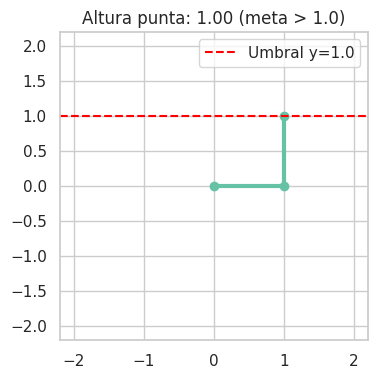

0.9999999999999999

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def tip_height(theta1, theta2, l1=1.0, l2=1.0):
    return -l1 * np.cos(theta1) - l2 * np.cos(theta1 + theta2)

def plot_acrobot(theta1, theta2, l1=1.0, l2=1.0, goal=1.0):
    # Posiciones de las articulaciones
    x0, y0 = 0.0, 0.0
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta1 + theta2)
    y2 = y1 - l2 * np.cos(theta1 + theta2)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot([x0, x1, x2], [y0, y1, y2], '-o', lw=3)
    ax.axhline(goal, color='red', linestyle='--', label=f'Umbral y={goal}')
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.2, 2.2)
    ax.set_title(f'Altura punta: {y2:.2f} (meta > {goal})')
    ax.legend()
    plt.show()
    return y2

# Ejemplo ilustrativo (ajusta θ_1, θ_2 si deseas)
theta1 = np.pi / 2  # 90°
theta2 = np.pi / 2  # 90°
h = tip_height(theta1, theta2)
print(f'Altura h = {h:.2f} (éxito si h > 1.0)')
plot_acrobot(theta1, theta2)


---
## **PARTE 1** - Entorno de trabajo con Docker (local)

En este proyecto se trabaja en un entorno **dockerizado** para asegurar reproducibilidad: misma versión de Python (3.8), mismas dependencias y mismo comportamiento en cualquier equipo. Además, el entrenamiento se ejecuta en **CPU** porque Acrobot es un entorno de **estado de baja dimensión** y el DQN utiliza una **MLP pequeña** (un par de capas densas) suficiente para aproximar $Q(s,a)$ en tareas de control clásico; en esta escala el coste computacional es bajo y no compensa la complejidad de GPU [1].

Para la visualización sin GUI se usa el modo `rgb_array` del entorno y generamos un MP4 a partir de los frames [1]. A continuación se describen los pasos para construir el entorno, ejecutar Jupyter Lab y entrenar/evaluar dentro del contenedor.


---
### 1.1. Construcción de la imagen Docker

La imagen se define en `docker/Dockerfile` y fija Python 3.8 junto con todas las dependencias del proyecto. Esto evita incompatibilidades entre equipos y permite repetir los resultados en cualquier máquina.

Se construye la imagen (solo la primera vez o cuando se cambien dependencias) utilizando el siguiente comando:
```bash
docker compose build
```


---
### 1.2. Jupyter Lab en Docker

El servicio `jupyter` del `docker-compose.yml` expone el puerto 8888 y monta el repositorio en `/workspace`.

Para poder renderizar y generar video sin entorno gráfico, se levanta un **display virtual** (Xvfb) y se definen las variables:
- `PYGLET_HEADLESS=1`: activa el modo headless de `pyglet` (no intenta abrir una ventana real).
- `SDL_VIDEODRIVER=dummy`: usa un backend de video falso para entornos sin pantalla.
- `DISPLAY=:99`: apunta al display virtual creado por Xvfb (el número 99 es el identificador del display).

El servicio se inicia así:
```bash
docker compose up jupyter
```

Se abre el navegador en:
```
http://localhost:8888/lab?token=TU_TOKEN
```
El token aparece en la salida del comando. Para detener el servicio, se usa `Ctrl+C`.


---
### 1.3. Entrenamiento y evaluación (Docker)

El entrenamiento y la evaluación se ejecutan dentro del contenedor usando los scripts del proyecto. Se dispone de tres comandos principales:

El archivo `config.yaml` se usa para **modificar hiperparámetros directamente** (red, entrenamiento, exploración, etc.), lo que permite controlar y comparar mejoras del modelo desde un único punto de configuración.

**1) Entrenamiento**
```bash
./docker_train.sh configs/dqn_base.yaml dqn_base_01
```
- `configs/dqn_base.yaml`: archivo de configuración con hiperparámetros (entorno, red, training, etc.).
- `dqn_base_01`: identificador del run; se usa para nombrar carpetas y archivos de salida.

**2) Evaluación**
```bash
./docker_eval.sh outputs/runs/dqn_base_01/config.yaml outputs/weights/dqn_base_01_weights.h5 100 dqn_base_01
```
- `outputs/runs/dqn_base_01/config.yaml`: misma configuración usada en entrenamiento.
- `outputs/weights/dqn_base_01_weights.h5`: pesos del modelo entrenado.
- `100`: número de episodios de test.
- `dqn_base_01`: si se indica, guarda métricas y figuras en `outputs/runs/dqn_base_01/`.

**3) Entrenamiento + evaluación**
```bash
./docker_train_eval.sh configs/dqn_base.yaml dqn_base_01 100
```
- `configs/dqn_base.yaml`: configuración base.
- `dqn_base_01`: identificador del run.
- `100`: episodios de evaluación al terminar el entrenamiento.

Los resultados quedan en `outputs/runs/<run_id>/` (config, logs, métricas y figuras) y los pesos en `outputs/weights/`.


---
### 1.4. Estructura de directorios y clases

La organización del proyecto separa configuración, scripts, código y salidas de forma reproducible:

```text
08MIAR_PROYECTO/
├─ configs/                 # Configuración de experimentos (YAML)
├─ docker/                  # Dockerfile y documentación
├─ scripts/                 # Entrypoints CLI (train/eval)
├─ src/
│  └─ acrobot_dqn/           # Implementación principal DQN
│     ├─ agent.py            # Agente DQN y políticas
│     ├─ eval.py             # Evaluación
│     ├─ model.py            # Arquitectura de red
│     ├─ plots.py            # Gráficas
│     ├─ render.py           # Video MP4 headless
│     ├─ trainer.py          # Entrenamiento
│     └─ utils.py            # Utilidades (config, seeds)
├─ outputs/                 # Runs, métricas, figuras, pesos
├─ books/                   # Bibliografía
└─ references/              # Referencias en IEEE
```

**Clases principales (DQN):**
- `DQNModelBuilder` (`src/acrobot_dqn/model.py`): construye la MLP para aproximar $Q(s,a)$.
- `DQNAgentFactory` (`src/acrobot_dqn/agent.py`): crea el agente DQN con replay buffer, política $ε$‑greedy y variantes.
- `DQNTrainer` (`src/acrobot_dqn/trainer.py`): ejecuta el entrenamiento, guarda logs, checkpoints y figuras.
- `DQNEvaluator` (`src/acrobot_dqn/eval.py`): evalúa en episodios de test y guarda métricas/gráficas.
- `EpisodeVideoRecorder` (`src/acrobot_dqn/render.py`): genera MP4 desde `rgb_array` en modo headless.

**Módulos de soporte:**
- `plots.py`: utilidades para gráficas de entrenamiento y evaluación.
- `utils.py`: carga/guarda de configuración, semillas y gestión de directorios.

**Scripts (CLI):**
- `scripts/train.py`: entrena un run a partir de un `config.yaml`.
- `scripts/eval.py`: evalúa pesos entrenados y genera métricas/figuras.

Esta separación permite modificar hiperparámetros desde `configs/` sin tocar el código, y centraliza los resultados en `outputs/` para su análisis.


### Video de referencia (archivo local)

Si no se visualiza, marca el notebook como **Trusted** y verifica que exista `outputs/renders/ejemplo_acrobot.mp4`.

<video width="600" controls>
  <source src="outputs/renders/ejemplo_acrobot.mp4" type="video/mp4">
</video>


---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que se trabajará será [Acrobot_V1](https://gymnasium.farama.org/environments/classic_control/acrobot/) y el algoritmo que se usará será _DQN_.

- Para este ejercicio, el requisito mínimo será **alcanzar el objetivo de altura durante 100 episodios de test consecutivos**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [ ]:
import sys
from pathlib import Path
import json
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, Video, HTML, display

ROOT = Path('.').resolve()
sys.path.append(str(ROOT / 'src'))

from acrobot_dqn.plots import plot_training_logs, plot_eval_results
from acrobot_dqn.utils import set_seeds
from acrobot_dqn.model import DQNModelBuilder
from acrobot_dqn.agent import DQNAgentFactory
from acrobot_dqn.render import EpisodeVideoRecorder

import tensorflow as tf


### Visualización del entorno (episodio aleatorio)

Para observar la dinámica del Acrobot sin GUI, se capturan frames con `rgb_array` y se codifican a MP4 [1].


In [41]:
ENV_NAME_RENDER = 'Acrobot-v1'
VIDEO_DIR = Path('outputs') / 'renders'
RANDOM_VIDEO = VIDEO_DIR / 'acrobot_random.mp4'

def random_policy(state, env):
    return env.action_space.sample()

recorder = EpisodeVideoRecorder(fps=30, max_steps=500)
random_video_path = recorder.record(
    ENV_NAME_RENDER,
    policy_fn=random_policy,
    out_path=RANDOM_VIDEO,
)
print(f'Video guardado en: {random_video_path}')
display(Video(str(random_video_path), embed=True))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x227ed380] Warning: data is not aligned! This can lead to a speed loss


Video guardado en: outputs/renders/acrobot_random.mp4


#### Configuracion del run base (contexto del reporte)

Esta celda selecciona el `RUN_ID` que vas a documentar y carga su configuracion, rutas y logs para el resto de la PARTE 3.


In [42]:
# Run base que se reporta en la PARTE 3
RUN_ID = 'dqn_base_00'

RUN_DIR = Path('outputs') / 'runs' / RUN_ID
CONFIG_PATH = RUN_DIR / 'config.yaml'
EVAL_PATH = RUN_DIR / 'metrics' / 'eval.json'
FIG_DIR = RUN_DIR / 'figures'

if not CONFIG_PATH.exists():
    raise FileNotFoundError(f'No se encontro {CONFIG_PATH}. Asegura que el run existe.')

cfg = yaml.safe_load(CONFIG_PATH.read_text(encoding='utf-8'))
ENV_NAME = cfg.get('env_name', 'Acrobot-v1')
LOG_PATH = RUN_DIR / 'logs' / f'dqn_{ENV_NAME}_log.json'

def display_two_columns(df):
    mid = (len(df) + 1) // 2
    left = df.iloc[:mid]
    right = df.iloc[mid:]
    html = f'''
<div style="display:flex; gap:16px; align-items:flex-start;">
  <div style="flex:1;">{left.to_html()} </div>
  <div style="flex:1;">{right.to_html()} </div>
</div>
'''
    display(HTML(html))


In [ ]:
SEED = int(cfg.get('seed', 123))
set_seeds(SEED)
print(f'Semilla global configurada: {SEED}')


1. Implementación de la red neuronal

La red para **Acrobot** no trabaja con píxeles, sino con el vector de estado continuo de 6 dimensiones. Por ello se utiliza una **MLP** sencilla que aproxima la función de valor de acción $Q_	heta(s,a)$, siguiendo la formulación de DQN [1]. En esta arquitectura, el estado se aplana y pasa por dos capas densas con activación ReLU; la salida produce un valor por acción discreta.

La elección de una MLP (en lugar de CNN) se justifica porque el espacio de observaciones no contiene estructura espacial, y el objetivo es aproximar $Q(s,a)$ de forma estable y eficiente [1], [2].


#### 1.1. Visualización del modelo implementado

A continuación se instancia la red **exactamente** desde las clases del proyecto (`DQNModelBuilder`) y se muestra su `summary()` para evidenciar la implementación real.


In [43]:
import gym

env_tmp = gym.make(ENV_NAME)
nb_actions = env_tmp.action_space.n
obs_shape = env_tmp.observation_space.shape
env_tmp.close()

model_builder = DQNModelBuilder(
    hidden_units=cfg.get('model', {}).get('hidden_units', [128, 128]),
    activation=cfg.get('model', {}).get('activation', 'relu'),
)
model = model_builder.build(obs_shape, nb_actions)

model.summary()

try:
    import tensorflow as tf
    from IPython.display import display
    display(tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True))
except Exception as e:
    print('plot_model no disponible en este entorno:', e)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 6)                 0         
                                                                 
 dense_18 (Dense)            (None, 128)               896       
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 17,795
Trainable params: 17,795
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [ ]:
# Hiperparametros de la RED (no del agente completo)
import gym

env_tmp = gym.make(ENV_NAME)
nb_actions = env_tmp.action_space.n
obs_shape = env_tmp.observation_space.shape
env_tmp.close()

model_cfg = cfg.get('model', {})
model_params = {
    'model.hidden_units': model_cfg.get('hidden_units'),
    'model.activation': model_cfg.get('activation'),
    'observation_dim': int(np.prod(obs_shape)),
    'nb_actions': int(nb_actions),
}
# Convertimos valores potencialmente complejos (listas) a texto para mostrarlos en una sola columna.
model_params = {k: repr(v) for k, v in model_params.items()}
model_df = pd.DataFrame.from_dict(model_params, orient='index', columns=['value'])
display_two_columns(model_df)


2. Implementación de la solución DQN

Se implementa DQN con: (i) **replay buffer** para romper correlaciones, (ii) política $\epsilon$-greedy con *annealing*, y (iii) *target network* opcionalmente actualizado cada cierto número de pasos, lo cual estabiliza el aprendizaje [1]. Las variantes **Double DQN** y **Dueling DQN** se activan con banderas, siguiendo las propuestas de estabilización y mejora del estimador de $Q$ descritas en [1].

La función objetivo se basa en el target de Bellman:

$$y(s,a)=r + \gamma \max_{a'} Q_{\theta^-}(s',a')$$

y la pérdida se minimiza típicamente con MSE o Huber:

$$\mathcal{L}(\theta)=\mathbb{E}\left[(y(s,a)-Q_{\theta}(s,a))^2\right].$$



#### 2.1. Instanciacion del agente DQN y sus hiperparametros

Primero se instancia el agente con `DQNAgentFactory(cfg)` para mostrar como la red se conecta con memoria, politica y variantes. Luego se listan los hiperparametros del agente con el mismo formato en dos columnas.


In [45]:
env_tmp = gym.make(ENV_NAME)
nb_actions = env_tmp.action_space.n
obs_shape = env_tmp.observation_space.shape
env_tmp.close()

model = DQNModelBuilder(
    hidden_units=cfg['model']['hidden_units'],
    activation=cfg['model']['activation'],
).build(obs_shape, nb_actions)

agent = DQNAgentFactory(cfg).build(model, nb_actions)

dqn_params = {
    'memory_limit': cfg.get('memory_limit'),
    'window_length': cfg.get('window_length'),
    'policy.eps_max': cfg.get('policy', {}).get('eps_max'),
    'policy.eps_min': cfg.get('policy', {}).get('eps_min'),
    'policy.eps_test': cfg.get('policy', {}).get('eps_test'),
    'policy.anneal_steps': cfg.get('policy', {}).get('anneal_steps'),
    'training.nb_steps': cfg.get('training', {}).get('nb_steps'),
    'training.warmup_steps': cfg.get('training', {}).get('warmup_steps'),
    'training.gamma': cfg.get('training', {}).get('gamma'),
    'training.learning_rate': cfg.get('training', {}).get('learning_rate'),
    'training.target_model_update': cfg.get('training', {}).get('target_model_update'),
    'variants.double_dqn': cfg.get('variants', {}).get('double_dqn'),
    'variants.dueling_dqn': cfg.get('variants', {}).get('dueling_dqn'),
    'variants.dueling_type': cfg.get('variants', {}).get('dueling_type'),
}
dqn_params = {k: repr(v) for k, v in dqn_params.items()}
dqn_df = pd.DataFrame.from_dict(dqn_params, orient='index', columns=['value'])
display_two_columns(dqn_df)


,value
memory_limit,100000
window_length,1
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02
policy.anneal_steps,50000
training.nb_steps,200000
,value
training.warmup_steps,1000
training.gamma,0.99


#### 2.3. Resultados del run base: entrenamiento

Estas graficas salen del log guardado durante el entrenamiento (`FileLogger`).


In [46]:
# Graficas de entrenamiento (se generan a partir del log)
if LOG_PATH.exists():
    plot_training_logs(LOG_PATH, FIG_DIR)
    img_a = FIG_DIR / 'training_reward.png'
    img_b = FIG_DIR / 'training_mean_q.png'
    if img_a.exists() and img_b.exists():
        html = f'''
<div style="display:flex; gap:16px;">
  <div style="flex:1;"><img src="{img_a.as_posix()}" style="width:100%;"></div>
  <div style="flex:1;"><img src="{img_b.as_posix()}" style="width:100%;"></div>
</div>
'''
        display(HTML(html))
    else:
        for img_path in [img_a, img_b]:
            if img_path.exists():
                display(Image(filename=str(img_path)))
else:
    print(f'No se encontro el log: {LOG_PATH}')


#### 2.4. Resultados del run base: evaluacion

Aqui se resumen metricas clave y se muestran las graficas de evaluacion.


In [47]:
# Cargar resultados de evaluación
if EVAL_PATH.exists():
    results = json.loads(EVAL_PATH.read_text(encoding='utf-8'))
    display(pd.DataFrame([{
        'successes': results.get('successes'),
        'success_rate': results.get('success_rate'),
        'mean_reward': results.get('mean_reward'),
    }]))
    plot_eval_results(results, FIG_DIR)
    img_a = FIG_DIR / 'eval_rewards.png'
    img_b = FIG_DIR / 'eval_rewards_hist.png'
    if img_a.exists() and img_b.exists():
        html = f'''
<div style="display:flex; gap:16px;">
  <div style="flex:1;"><img src="{img_a.as_posix()}" style="width:100%;"></div>
  <div style="flex:1;"><img src="{img_b.as_posix()}" style="width:100%;"></div>
</div>
'''
        display(HTML(html))
    else:
        for img_path in [img_a, img_b]:
            if img_path.exists():
                display(Image(filename=str(img_path)))
else:
    print(f'No se encontro el archivo: {EVAL_PATH}')
    


,successes,success_rate,mean_reward
0,100,1.0,-88.23


#### 2.5. Visualizacion de la politica entrenada (run base)

Se graba un episodio con el agente entrenado usando `rgb_array` y se guarda en MP4.


In [48]:
VIDEO_DIR = Path('outputs') / 'renders'
TRAINED_VIDEO = VIDEO_DIR / f'{RUN_ID}_policy.mp4'
WEIGHTS_PATH = Path('outputs') / 'weights' / f'{RUN_ID}_weights.h5'
ALT_WEIGHTS_PREFIX = Path('outputs') / 'weights' / f'{RUN_ID}_weights.h5f'
ALT_WEIGHTS_INDEX = Path(str(ALT_WEIGHTS_PREFIX) + '.index')

if not WEIGHTS_PATH.exists() and ALT_WEIGHTS_INDEX.exists():
    WEIGHTS_PATH = ALT_WEIGHTS_PREFIX

if not WEIGHTS_PATH.exists() and not ALT_WEIGHTS_INDEX.exists():
    print(f'No se encontro el archivo de pesos: {WEIGHTS_PATH}')
else:
    import gym
    tmp_env = gym.make(ENV_NAME)
    nb_actions = tmp_env.action_space.n
    obs_shape = tmp_env.observation_space.shape
    tmp_env.close()

    model = DQNModelBuilder(
        hidden_units=cfg.get('model', {}).get('hidden_units', [128, 128]),
        activation=cfg.get('model', {}).get('activation', 'relu'),
    ).build(obs_shape, nb_actions)
    agent = DQNAgentFactory(cfg).build(model, nb_actions)
    agent.load_weights(str(WEIGHTS_PATH))

    def dqn_policy(state, env):
        return agent.forward(state)

    def reset_agent():
        agent.reset_states()

    recorder = EpisodeVideoRecorder(fps=30, max_steps=500, seed=cfg.get('seed', 42))
    trained_video_path = recorder.record(
        ENV_NAME,
        policy_fn=dqn_policy,
        out_path=TRAINED_VIDEO,
        reset_fn=reset_agent,
    )
    print(f'Video guardado en: {trained_video_path}')
    display(Video(str(trained_video_path), embed=True))


/usr/local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0xacba380] Warning: data is not aligned! This can lead to a speed loss


Video guardado en: outputs/renders/dqn_base_00_policy.mp4


3. Justificacion de los parametros seleccionados y de los resultados obtenidos

En esta seccion se justifica la arquitectura de la red, la construccion del agente DQN y la seleccion del conjunto inicial de hiperparametros. La idea es dejar claro que el run base no es arbitrario: es un punto de partida tecnico y defendible desde la teoria y la practica de DQN en control clasico [1], [2], y desde la naturaleza del entorno Acrobot [3].

#### 3.1. Justificacion del modelo de la red (MLP para Q(s,a))

Acrobot no entrega imagenes, sino un vector continuo de baja dimension (senos, cosenos y velocidades angulares). En este tipo de observaciones no hay estructura espacial que aprovechar con convoluciones, por lo que una MLP es la eleccion natural para aproximar $Q_\theta(s,a)$ [1], [2], [3]. Ademas, una red pequena (por ejemplo, dos capas densas) suele ser suficiente para capturar no linealidades relevantes sin introducir una capacidad excesiva que complique la estabilidad del entrenamiento en DQN [1].

La salida lineal con un valor por accion discreta implementa exactamente la formulacion de DQN: estimar valores de accion para seleccionar $\arg\max_a Q_\theta(s,a)$. Esta coherencia entre arquitectura y objetivo es una parte importante de la justificacion tecnica [1], [2].

#### 3.2. Justificacion de la solucion DQN (piezas de estabilidad)

DQN no es solo una red que aprende por TD: necesita mecanismos adicionales para evitar inestabilidades. El *replay buffer* reduce la correlacion temporal entre transiciones y mejora la calidad estadistica de los lotes de entrenamiento. La *target network* desacopla el objetivo de Bellman de la red online, reduciendo oscilaciones y divergencias por retroalimentacion rapida. Por ultimo, la exploracion $\epsilon$-greedy con *annealing* permite una fase inicial fuertemente exploratoria y una fase posterior mas explotadora. Estas tres piezas son, en la practica, el nucleo de por que DQN funciona de forma razonablemente estable [1], [2].

#### 3.3. Justificacion hiperparametro por hiperparametro (run base)

A continuacion, cada hiperparametro relevante se justifica de forma explicita, como un compromiso tecnico razonable para un run base.

**`model.hidden_units` (p. ej. [128, 128]).** En control clasico con estado de baja dimension, una MLP con dos capas densas moderadas suele ofrecer suficiente capacidad para aproximar funciones $Q$ no lineales sin hacer el ajuste demasiado delicado. Es un tamano comun como punto de partida antes de explorar redes mas grandes [1], [2].

**`model.activation` (ReLU).** ReLU es una eleccion estandar por su simplicidad, buen comportamiento numerico y capacidad para modelar no linealidades sin saturar como otras activaciones clasicas. En MLPs para DQN suele funcionar bien como baseline [1].

**`training.gamma = 0.99`.** El objetivo de Acrobot requiere planificacion a varios pasos (swing-up). Un descuento alto prioriza el retorno a largo plazo, lo cual es consistente con la naturaleza del problema y con recomendaciones habituales en DQN [1], [2], [3].

**`training.learning_rate = 1e-3` (Adam).** Un learning rate de $10^{-3}$ con Adam es un punto de partida habitual: no es extremadamente agresivo, pero tampoco tan pequeno que ralentice demasiado el aprendizaje inicial. Es razonable para un run base que luego se afinara en la seccion de mejoras [1].

**`training.target_model_update` (p. ej. 1000).** Actualizar el target cada cierto numero de pasos introduce inercia en el objetivo de Bellman. Valores del orden de miles de pasos suelen ser un buen compromiso entre estabilidad (targets mas lentos) y velocidad de adaptacion (targets no demasiado viejos) [1], [2].

**`memory_limit` (p. ej. 100000).** Un buffer amplio permite cubrir mas regiones del espacio de estados y reduce el riesgo de sobreajuste a experiencia muy reciente. Para entornos pequenos como Acrobot, este tamano es manejable y suficientemente rico para un baseline [1], [2].

**`training.warmup_steps` (p. ej. 1000).** Entrenar demasiado pronto puede sesgar las actualizaciones con experiencia muy pobre o poco diversa. Un warmup inicial permite llenar parcialmente la memoria antes de aprender, lo que mejora la estabilidad temprana [1], [2].

**Exploracion: `eps_max`, `eps_min`, `anneal_steps`, `eps_test`.** Comenzar con $\epsilon$ alto fuerza exploracion amplia cuando el agente aun no sabe nada. Reducirlo gradualmente mantiene exploracion suficiente pero permite consolidar una politica mas determinista. Separar un `eps_test` pequeno evita que la evaluacion subestime la politica por exceso de aleatoriedad [1], [2].

**`training.nb_steps`.** En DQN la cantidad de pasos totales controla cuanto tiempo tiene el agente para poblar el buffer, refinar el estimador y estabilizar el comportamiento. Un run base con un presupuesto amplio de pasos es coherente con el objetivo de llegar a 100/100 en test antes de comparar variantes [1], [2].

#### 3.4. Justificacion de como se leen y comparan los resultados

En Acrobot, la recompensa esta muy ligada al numero de pasos hasta el exito, y el criterio academico clave suele expresarse como porcentaje de episodios exitosos. Por eso es importante reportar conjuntamente `success_rate` y `mean_reward`, y mantener el mismo protocolo de evaluacion cuando se comparan mejoras. Cuando aparecen outliers negativos, la estrategia mas defendible es ajustar primero estabilidad (por ejemplo, learning rate y target update) y luego exploracion, documentando cada cambio y su efecto [1]--[3].

**Referencias (IEEE)**

[1] A. Geron, *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 3rd ed., 2025, ch. 18.

[2] R. S. Sutton and A. G. Barto, *Reinforcement Learning: An Introduction*, 2nd ed., MIT Press, 2020.

[3] Farama Foundation, "Acrobot-v1," *Gymnasium Documentation*, 2025.


---
## 4. Experimentos y mejoras iterativas

En esta sección se propondrá un **modelo base** y luego se irán comparando mejoras de forma ordenada:

1) Se define un cambio concreto de hiperparámetros.
2) Se entrena con un nuevo `run_id`.
3) Se reportan métricas y figuras.
4) Se compara contra el base con el mismo criterio.


#### 4.1. Plantilla mínima para cada experimento

- `config`: ...
- `run_id`: ...
- cambio respecto al base: ...
- resultados clave: `success_rate`, `mean_reward`, outliers.
- decisión: ¿mejora o no mejora?


#### 4.2. Plantilla ejecutable: base vs mejoras

Define el run base y una lista de runs candidatos, y luego compara metricas e hiperparametros clave con el mismo criterio.


In [ ]:
BASE_RUN_ID = 'dqn_base_00'
CANDIDATE_RUN_IDS = [
    # 'dqn_base_01',
    # 'dqn_double_01',
]
ALL_RUN_IDS = [BASE_RUN_ID] + [r for r in CANDIDATE_RUN_IDS if r]
ALL_RUN_IDS


In [ ]:
from pathlib import Path
import json
import yaml
import pandas as pd

def load_run(run_id):
    run_dir = Path('outputs') / 'runs' / run_id
    cfg_path = run_dir / 'config.yaml'
    eval_path = run_dir / 'metrics' / 'eval.json'

    if not cfg_path.exists():
        raise FileNotFoundError(cfg_path)

    cfg = yaml.safe_load(cfg_path.read_text(encoding='utf-8'))
    metrics = json.loads(eval_path.read_text(encoding='utf-8')) if eval_path.exists() else {}
    return run_dir, cfg, metrics

def summarize_run(run_id):
    run_dir, cfg, metrics = load_run(run_id)
    return {
        'run_id': run_id,
        'success_rate': metrics.get('success_rate'),
        'mean_reward': metrics.get('mean_reward'),
        'learning_rate': cfg.get('training', {}).get('learning_rate'),
        'target_model_update': cfg.get('training', {}).get('target_model_update'),
        'eps_min': cfg.get('policy', {}).get('eps_min'),
        'anneal_steps': cfg.get('policy', {}).get('anneal_steps'),
        'hidden_units': cfg.get('model', {}).get('hidden_units'),
        'double_dqn': cfg.get('variants', {}).get('double_dqn'),
        'dueling_dqn': cfg.get('variants', {}).get('dueling_dqn'),
        'run_dir': run_dir.as_posix(),
    }


In [ ]:
rows = []
for run_id in ALL_RUN_IDS:
    try:
        rows.append(summarize_run(run_id))
    except FileNotFoundError as e:
        print(f'Run incompleto o inexistente: {run_id} -> {e}')

comparison_df = pd.DataFrame(rows)
comparison_df


In [ ]:
from IPython.display import HTML, display

def show_run_figures(run_id):
    run_dir = Path('outputs') / 'runs' / run_id
    fig_dir = run_dir / 'figures'
    imgs = [
        fig_dir / 'training_reward.png',
        fig_dir / 'training_mean_q.png',
        fig_dir / 'eval_rewards.png',
        fig_dir / 'eval_rewards_hist.png',
    ]
    existing = [p for p in imgs if p.exists()]
    if not existing:
        print(f'No hay figuras para {run_id} en {fig_dir}')
        return
    html = '<div style="display:grid;grid-template-columns:1fr 1fr;gap:12px;">'
    for p in existing:
        html += f'<div><img src="{p.as_posix()}" style="width:100%;"></div>'
    html += '</div>'
    display(HTML(html))

# Ejemplo:
# show_run_figures(BASE_RUN_ID)


---

**Referencias (IEEE)**

[1] A. Geron, *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 3rd ed., 2025, ch. 18.

[2] R. S. Sutton and A. G. Barto, *Reinforcement Learning: An Introduction*, 2nd ed., MIT Press, 2020.

[3] Farama Foundation, "Acrobot-v1," *Gymnasium Documentation*, 2025.